# Flexible BAO examples

In this notebook we will explore a flexible parameterization of the BAO model fitted to data power spectrum and correlation function.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## BAO likelihood
Let us define the power spectrum BAO likelihood, generating fake synthetic data.

In [1]:
import numpy as np

from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, FlexibleBAOWigglesTracerPowerSpectrumMultipoles, FlexibleBAOWigglesTracerCorrelationFunctionMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, TracerCorrelationFunctionMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging

setup_logging()

z = 1.
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = FlexibleBAOWigglesTracerPowerSpectrumMultipoles(template=template, broadband='pcs', wiggles='pcs')
params = {'b1': 2.}
# Generate synthetic monopole and quadrupole, between 0.02 and 0.35 h/Mpc
observable = TracerPowerSpectrumMultipolesObservable(data=params, covariance=None,
                                                     klim={0: [0.005, 0.35, 0.005], 2: [0.005, 0.35, 0.005]},
                                                     theory=theory)

observable.init.update(data=observable.flatdata)  # fix the data vector

from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix

footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
likelihood = ObservablesGaussianLikelihood(observables=[observable], covariance=covariance(**params))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


## Broadband
The broadband is parameterized as a sum of TSC (or PCS) kernels located at periodically separated pivot points.

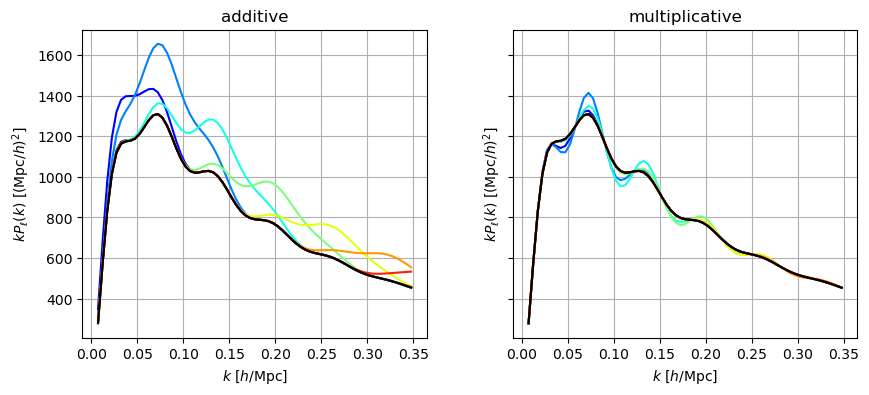

In [2]:
from matplotlib import pyplot as plt

fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, mode in enumerate(['additive', 'multiplicative']):
    ax = lax[iax]
    names = theory.all_params.names(basename=mode[0] + 'l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        pk = theory(**{name: 2.})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.k, theory.k * pk[ill], color=cmap(iname * 1. / len(names)))
        pk = theory(**{name: 0.})
    ax.plot(theory.k, theory.k * pk[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(mode)
plt.show()

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

for param in likelihood.all_params.select(basename=['al*', 'ml*']):
    param.update(derived='.auto')
profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize(niterations=2)

[000007.58] [0/1] 10-27 21:05  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1'].
[000007.86] [0/1] 10-27 21:05  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_-1', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7'].
[000015.18] [0/1] 10-27 21:06  Differentiation           INFO     Differentiation will evaluate 1 points.
[000018.59] [0/1] 10-27 21:06  TaskManager               INFO     Entering TaskManager with 1 workers.


In [4]:
print(profiles.to_stats(tablefmt='pretty'))

+--------------------------------------+--------+----------+-------+
| chi2 / (138 - 39) = 0.00 / 99 = 0.00 | varied | bestfit  | error |
+--------------------------------------+--------+----------+-------+
|                 qpar                 |  True  |  1.000   | 0.018 |
|                 qper                 |  True  |  1.000   | 0.015 |
|                  b1                  |  True  |   2.00   | 0.49  |
|                ml0_-1                |  True  |   0.20   |       |
|                ml0_0                 |  True  | -0.0020  |       |
|                ml0_1                 |  True  |  0.0014  |       |
|                ml0_2                 |  True  |  4.4e-4  |       |
|                ml0_3                 |  True  |  0.0013  |       |
|                ml0_4                 |  True  | 0.00064  |       |
|                ml0_5                 |  True  |  0.0011  |       |
|                ml0_6                 |  True  |  -0.014  |       |
|                ml0_7            

[000036.33] [0/1] 10-27 21:06  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000036.34] [0/1] 10-27 21:06  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000036.45] [0/1] 10-27 21:06  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000036.46] [0/1] 10-27 21:06  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


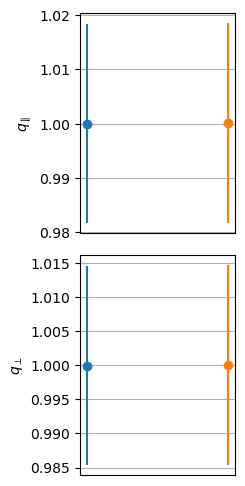

In [5]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiles, params=['qpar', 'qper']);

[000036.51] [0/1] 10-27 21:06  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_-1', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7'].
[000043.16] [0/1] 10-27 21:06  Differentiation           INFO     Differentiation will evaluate 1 points.


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/observables/galaxy_clustering/power_spectrum.py:315: UserWarning: plot_wiggles is deprecated, use plot_bao instead
  warnings.warn('plot_wiggles is deprecated, use plot_bao instead')


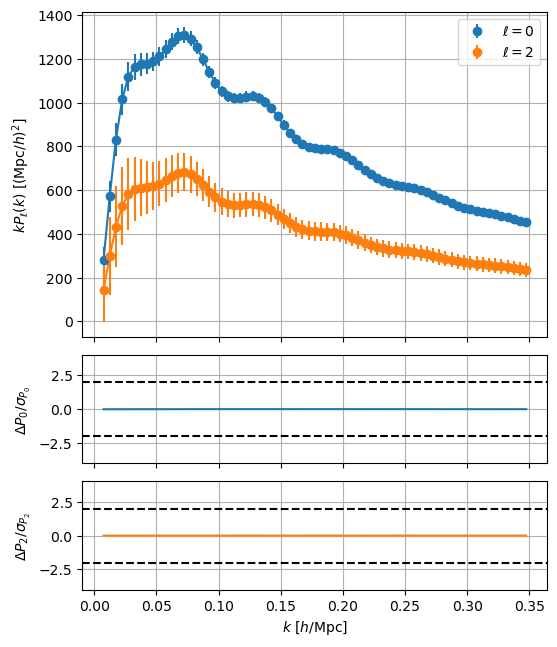

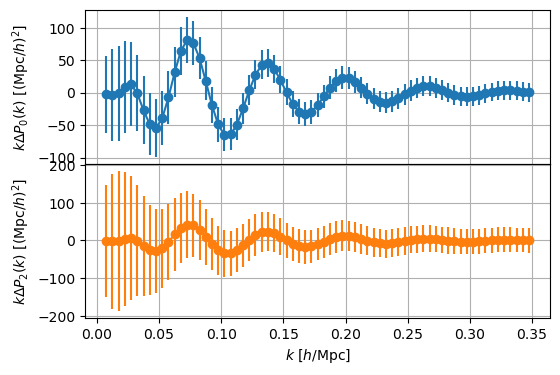

In [6]:
likelihood(**profiler.profiles.bestfit.choice(params=likelihood.varied_params))
observable.plot()
observable.plot_wiggles();

## Detection level
Let us estimate the detection level, by running profiling without and with wiggles.

In [7]:
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

for param in likelihood.all_params.select(basename='al*'):
    param.update(derived='.auto')

grid = np.linspace(0.9, 1.1, 21)
profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
profiles_nowiggle = profiler.profile(params='qiso', grid=grid)

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000045.83] [0/1] 10-27 21:06  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000046.16] [0/1] 10-27 21:06  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7'].
[000049.43] [0/1] 10-27 21:06  Differentiation           INFO     Differentiation will evaluate 1 points.
[000051.26] [0/1] 10-27 21:06  TaskManager               INFO     Entering TaskManager with 1 workers.
[000055.57] [0/1] 10-27 21:06  TaskManager               INFO     Entering TaskManager with 1 workers.
[000055.66] [0/1] 10-27 21:06  TaskManager               INFO     Entering TaskManager with 1 workers.


In [8]:
template.init.update(only_now=False)

for param in likelihood.all_params.select(basename=['al*', 'ml*']):
    param.update(derived='.auto')

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
profiles = profiler.profile(params='qiso', grid=grid)

[000108.45] [0/1] 10-27 21:07  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000108.76] [0/1] 10-27 21:07  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_-1', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7'].
[000115.74] [0/1] 10-27 21:07  Differentiation           INFO     Differentiation will evaluate 1 points.
[000117.04] [0/1] 10-27 21:07  TaskManager               INFO     Entering TaskManager with 1 workers.
[000122.88] [0/1] 10-27 21:07  TaskManager               INFO     Entering TaskManager with 1 workers.
[000123.09] [0/1] 10-27 21:07  TaskManager               INFO     Entering TaskManager with 1 workers.


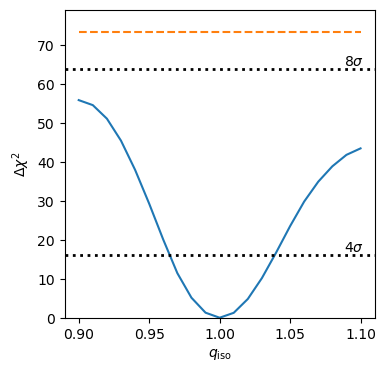

In [9]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[4, 8]);

## Convergence of broadband parameters
Let us study the convergence of the error on $q_{\mathrm{iso}}$ with the period of broadband kernels: the error remain stable as long as this period is larger than the BAO scale.

In [10]:
rs_drag = template.fiducial.rs_drag
fracs = np.linspace(0.5, 2., 15)
intervals = []

for frac in fracs:
    theory.init.update(kp=frac * 2. * np.pi / rs_drag)
    for param in likelihood.all_params.select(basename=['al*', 'ml*']): param.update(derived='.auto')
    profiler = MinuitProfiler(likelihood, seed=42)
    profiler.maximize(niterations=2)
    intervals.append(profiler.interval('qiso').interval['qiso'])

[000193.77] [0/1] 10-27 21:09  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000194.11] [0/1] 10-27 21:09  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_-1', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al0_8', 'al0_9', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7', 'al2_8', 'al2_9'].
[000202.27] [0/1] 10-27 21:09  Differentiation           INFO     Differentiation will evaluate 1 points.
[000206.10] [0/1] 10-27 21:09  TaskManager               INFO     Entering TaskManager with 1 workers.
[000234.21] [0/1] 10-27 21:09  TaskManager               INFO     Entering TaskManager with 1 workers.
[000268.07] [0/1] 10-27 21:10  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000268.45] [0/1] 10-27 21:10  Diff

[000600.36] [0/1] 10-27 21:15  TaskManager               INFO     Entering TaskManager with 1 workers.
[000610.77] [0/1] 10-27 21:15  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000611.09] [0/1] 10-27 21:15  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_-1', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000617.13] [0/1] 10-27 21:16  Differentiation           INFO     Differentiation will evaluate 1 points.
[000618.59] [0/1] 10-27 21:16  TaskManager               INFO     Entering TaskManager with 1 workers.
[000630.58] [0/1] 10-27 21:16  TaskManager               INFO     Entering TaskManager with 1 workers.
[000642.09] [0/1] 10-27 21:16  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000

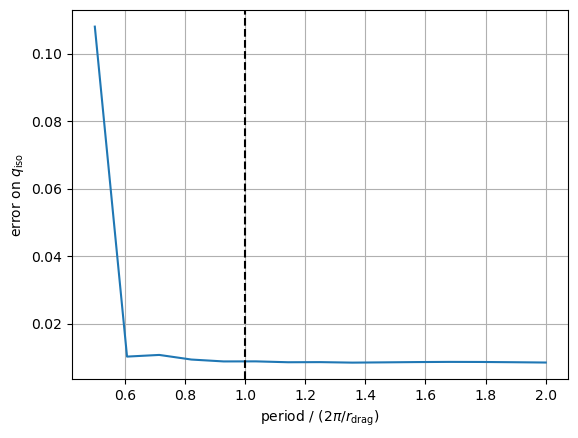

In [11]:
ax = plt.gca()
ax.plot(fracs, np.diff(intervals, axis=-1) / 2)
ax.set_xlabel(r'period / $(2 \pi / r_{\mathrm{drag}})$')
ax.set_ylabel(r'error on $q_{\mathrm{iso}}$')
ax.grid(True)
ax.axvline(x=1., color='k', linestyle='--')
plt.show()

## Correlation function
For the correlation function, *desilike* simply takes the Hankel transform of the above power spectrum theory multipoles. For additive terms however, as pointed out by Stephen Chen, the Fourier transform of the kernels will translate into oscillations for $s < 2 \pi / k_{p}$, which are usually outside of the fitting range. Instead, Stephen recommends add $s^{2n}$ terms, for $n = 0, 2$ --- these correspond to the small-$k$ power spectrum that are cut out of BAO $P(k)$ fits.

In [12]:
z = 1.
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso')
theory = FlexibleBAOWigglesTracerCorrelationFunctionMultipoles(template=template)
params = {'b1': 2.}
# Generate synthetic monopole and quadrupole, between 0.02 and 0.2 h/Mpc
observable = TracerCorrelationFunctionMultipolesObservable(data=params, covariance=None,
                                                           slim={0: [50., 150., 2.], 2: [50., 150., 2.]},
                                                           theory=theory)

observable.init.update(data=observable.flatdata)  # fix the data vector

from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix

footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
likelihood = ObservablesGaussianLikelihood(observables=[observable], covariance=covariance(**params))

/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


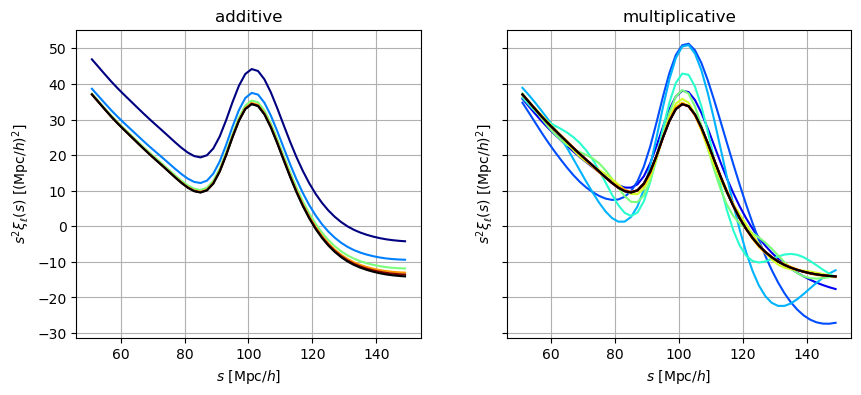

In [13]:
fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, mode in enumerate(['additive', 'multiplicative']):
    ax = lax[iax]
    names = theory.all_params.names(basename=mode[0] + 'l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        xi = theory(**{name: 1e-4 if iax == 0 else 2.})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.s, theory.s**2 * xi[ill], color=cmap(iname * 1. / len(names)))
        xi = theory(**{name: 0.})
    ax.plot(theory.s, theory.s**2 * xi[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    ax.set_ylabel(r'$s^{2} \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(mode)
plt.show()

In [14]:
rs_drag = template.fiducial.rs_drag
fracs_xi = np.linspace(0.7, 2., 15)
intervals_xi = []

for frac in fracs_xi:
    theory.init.update(kp=frac * 2. * np.pi / rs_drag)
    for param in likelihood.all_params.select(basename=['al*', 'ml*']): param.update(derived='.auto')
    profiler = MinuitProfiler(likelihood, seed=42)
    profiler.maximize(niterations=2)
    intervals_xi.append(profiler.interval('qiso').interval['qiso'])

[000792.62] [0/1] 10-27 21:18  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000793.49] [0/1] 10-27 21:19  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml0_8', 'ml0_9', 'ml2_-1', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'ml2_8', 'ml2_9', 'al0_-2', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al2_-2', 'al2_-1', 'al2_0', 'al2_1', 'al2_2'].
[000802.05] [0/1] 10-27 21:19  Differentiation           INFO     Differentiation will evaluate 1 points.
[000805.58] [0/1] 10-27 21:19  TaskManager               INFO     Entering TaskManager with 1 workers.
[000819.53] [0/1] 10-27 21:19  TaskManager               INFO     Entering TaskManager with 1 workers.
[000850.38] [0/1] 10-27 21:19  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000851.47] [0/1] 10-27 21:19  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 

[001296.68] [0/1] 10-27 21:27  Differentiation           INFO     Differentiation will evaluate 1 points.
[001300.88] [0/1] 10-27 21:27  TaskManager               INFO     Entering TaskManager with 1 workers.
[001315.92] [0/1] 10-27 21:27  TaskManager               INFO     Entering TaskManager with 1 workers.
[001333.56] [0/1] 10-27 21:28  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[001334.83] [0/1] 10-27 21:28  Differentiation           INFO     Varied parameters: ['ml0_-1', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_-1', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'al0_-2', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al2_-2', 'al2_-1', 'al2_0', 'al2_1', 'al2_2'].
[001340.16] [0/1] 10-27 21:28  Differentiation           INFO     Differentiation will evaluate 1 points.
[001342.34] [0/1] 10-27 21:28  TaskManager               INFO     Entering TaskManager with 1 workers.
[001360.27] [0/1] 10-27 21:28  Ta

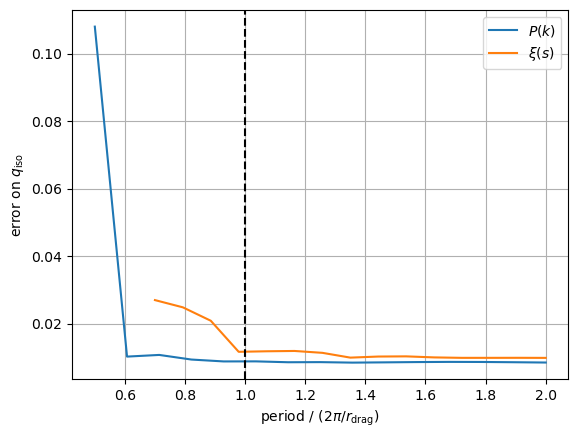

In [15]:
ax = plt.gca()
ax.plot(fracs, np.diff(intervals, axis=-1) / 2, label=r'$P(k)$')
ax.plot(fracs_xi, np.diff(intervals_xi, axis=-1) / 2, label=r'$\xi(s)$')
ax.set_xlabel(r'period / $(2 \pi / r_{\mathrm{drag}})$')
ax.set_ylabel(r'error on $q_{\mathrm{iso}}$')
ax.grid(True)
ax.axvline(x=1., color='k', linestyle='--')
ax.legend()
plt.show()